In [59]:
import tqdm

from across.BioTac_Signal_to_Deformation.src.model.projection_network import ProjectionNetworkBiotac
from across.BioTac_Signal_to_Deformation.src.dataset_loader.biotac_latent_space_loader import BioTacLatentSpaceModule
from across.BioTac_Signal_to_Deformation.src.dataset_loader.biotac_value_to_def_data_loader import BioTacValueDeformationModule
from across.Mesh_Reconstruction.src.model.fem_autoencoder import fem_VAE
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np

In [73]:
import torch

path= "../../Data/datasets/value_def_dataset/accepted_dataset_shuffled_nvidia_2_depth_filter_surface_adjusted_shuffled_nvidia_2.pt"

# read the data

data = torch.load(path)

In [64]:
depths=torch.cat([data["train"]["depth"],data["validation"]["depth"],data["test"]["depth"]],dim=0)

In [66]:
depths.shape

torch.Size([17644, 836])

In [67]:
torch.max(depths, dim=-1)[0].shape

torch.Size([17644])

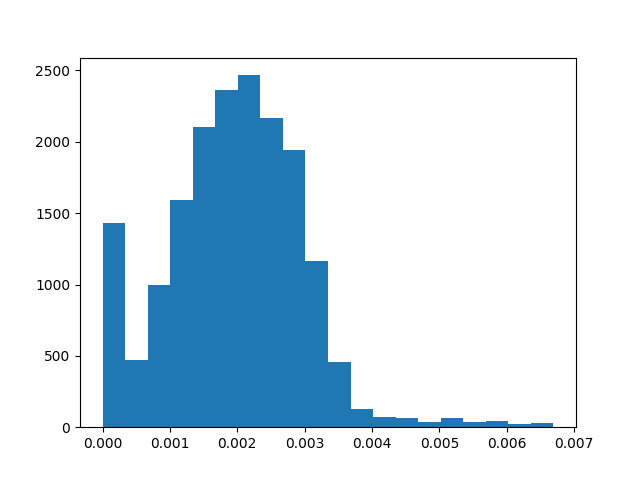

In [68]:
fig=plt.figure()
plt.hist(torch.max(depths, dim=-1)[0], bins=20)
plt.show()

In [21]:
vertices_biotac_surface = np.load(
        "../../Data/meshes/gel_surface/surface_hq_biotac_shifted.npy")  # this is the surface of the biotac, exported from the 3d model of the gel, and transformed to npy file.

vertices_biotac_template = np.load("template_mesh_vertices.npy")

In [35]:
vertices_surface_indices = []
for ind, i in enumerate(vertices_biotac_surface):
    if i[0]<0 and i[1]<0.002:
        # find nearest point in all_vertices_full
        vertices_surface_indices.append(np.argmin(np.linalg.norm(vertices_biotac_template-i, axis=1)))


vertices_surface_filterd = vertices_biotac_template[vertices_surface_indices]

# save vertices_surface_indices
np.save("vertices_surface_indices.npy", vertices_surface_indices)


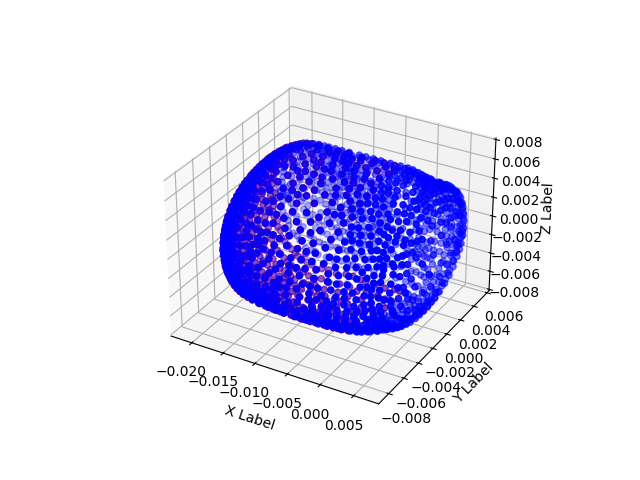

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(vertices_biotac_template[:,0], vertices_biotac_template[:,1], vertices_biotac_template[:,2], c='r', marker='o')
ax.scatter(vertices_biotac_surface[:,0], vertices_biotac_surface[:,1], vertices_biotac_surface[:,2], c='b', marker='o')

ax.scatter(vertices_surface_filterd[:,0], vertices_surface_filterd[:,1], vertices_surface_filterd[:,2], c='r', marker='o')

# add x,y,z axis
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [5]:
data["train"]["value"].shape

torch.Size([6133, 8])

In [2]:
deformation_network = fem_VAE.load_from_checkpoint(
    "../../Data/checkpoints/biotac_mesh_reconstruction/biotac_batch_size_128_kl_weight_0.005_cheb_order_6:z_128_lr_0.001_L_1_seed_76979_fem_VAE_allData/epoch=299-step=288300.ckpt",
    #"../BioTac_to_DIGIT_Deformation/src/checkpoints/biotac_batch_size_128_kl_weight_0.005_cheb_order_6:z_128_lr_0.001_L_1_seed_91612_fem_VAE_single_indenter/epoch=497-step=16932.ckpt",
    mean=0, std=1, z=128)

Generated transformation matrices


In [3]:
#model = ProjectionNetworkBiotac.load_from_checkpoint("../../Data/checkpoints/signal_to_mesh_projection/all_data/lr_0.005_seed_-1/epoch=732-step=2932.ckpt")
#model = ProjectionNetworkBiotac.load_from_checkpoint("../../Data/checkpoints/signal_to_mesh_projection/all_data/epoch=31-step=928_smac.ckpt")
model = ProjectionNetworkBiotac.load_from_checkpoint("../../Data/checkpoints/signal_to_mesh_projection/all_data/lr_0.005_seed_0/epoch=912-step=3652.ckpt")

model = model.to("cpu")
model.eval()

ProjectionNetworkBiotac(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [4]:
latent_space_module = BioTacLatentSpaceModule(data_file="../../Data/datasets/value_def_dataset/accepted_dataset_all_data_depth_filter.pt", batch_size=1, 
                                              use_mu=True)


deformation_norm_dict = torch.load("../../Data/datasets/processed/biotac_155605_dist_1_20_env_0_1_2_3_4_5_6_7_8_norm.pt")
deformation_norm_s = np.array([deformation_norm_dict['mean'].numpy(), deformation_norm_dict['std'].numpy()])

value_norms = torch.load("../../Data/datasets/biotac_signal_norms/value_norms_all_data.pt")
value_norms = np.array([value_norms['mean'].numpy(), value_norms['std'].numpy()])

real_values_dict = torch.load("../../Data/datasets/value_def_dataset/accepted_dataset_all_data_depth_filter.pt")


In [5]:
from across.BioTac_Signal_to_Deformation.src.model.projection_network import NetworkWrapper
import lightning
deformation_network.to("cpu")
model.reconstruction_model = NetworkWrapper(deformation_network)
model.norm = deformation_norm_dict

trainer = lightning.Trainer()
metric = trainer.validate(model=model, datamodule=latent_space_module)


/home/wadhah.zai/.conda/envs/lightning/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wadhah.zai/.conda/envs/lightning/lib/python3.1 ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/wadhah.zai/.conda/envs/lightning/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` o

Train Set Size: 3656
Validation Set Size: 944
Test Set Size: 4425
Combined Set Size: 9025


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 val_interpretable_loss     0.03993040323257446
        val_loss           0.023046260699629784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [6]:
print(metric)

[{'val_loss': 0.023046260699629784, 'val_interpretable_loss': 0.03993040323257446}]


In [7]:
#metric = trainer.test(model=model, datamodule=latent_space_module)

In [8]:
class FEMNetworkInput:
    def __init__(self, data):
        self.x = data
        self.num_graphs = len(self.x)
        self.edge_index = None


In [9]:
import torch
deformation_network = deformation_network.to("cpu")
latent_test = iter(latent_space_module.test_dataloader())
deformation_test = real_values_dict["test"]
index = 5
#all_loss = []
for i in range(index-1):
    next(latent_test)

inp, target = next(latent_test)
real_inp, real_target= deformation_test["real_value"][index], deformation_test["real_deformation"][index]
with torch.no_grad():
    predicted_latent = model.forward(inp.to("cpu")).to("cpu")
    predicted_loss = torch.sqrt(torch.nn.functional.mse_loss(predicted_latent, target))
    real_predicted = deformation_network.decode(predicted_latent.to("cpu")).to("cpu")
    target_decoded = deformation_network.decode(target.to("cpu"))
    print(real_predicted.shape)
    print(target_decoded.shape)
    #real_predicted = real_predicted.reshape(-1, deformation_network.filters[0])
    #target_decoded = target_decoded.reshape(-1, deformation_network.filters[0])
    real_loss = torch.sqrt(
        torch.nn.functional.mse_loss(
            real_predicted * deformation_norm_dict["std"],
            target_decoded * deformation_norm_dict["std"] )
    ) * 1000
    print(real_loss)
    print(predicted_latent.size())
    print(target_decoded.size())
    print(real_predicted.size())
    print(predicted_loss)
    #all_loss.append(real_loss)
    real_predicted_alt, _, _, _ = deformation_network.forward(FEMNetworkInput(torch.unsqueeze(real_target.to("cpu"), 0)))
    real_predicted_alt = real_predicted_alt[0].to("cpu")
    

torch.Size([1, 4246, 3])
torch.Size([1, 4246, 3])
tensor(0.1295)
torch.Size([1, 128])
torch.Size([1, 4246, 3])
torch.Size([1, 4246, 3])
tensor(0.3975)


In [10]:
import torch
deformation_network = deformation_network.to("cpu")
latent_test = iter(latent_space_module.test_dataloader())
deformation_test = real_values_dict["test"]
#index = 5
all_loss = []
#for i in range(index):
#    next(latent_test)
for index in tqdm.tqdm(range(len(deformation_test["real_value"]))):
    inp, target = next(latent_test)
    real_inp, real_target= deformation_test["real_value"][index], deformation_test["real_deformation"][index]
    with torch.no_grad():
        predicted_latent = model.forward(inp.to("cpu")).to("cpu")
        predicted_loss = torch.sqrt(torch.nn.functional.mse_loss(predicted_latent, target))
        real_predicted = deformation_network.decode(predicted_latent.to(deformation_network.device)).to("cpu")
        target_decoded = deformation_network.decode(target.to(deformation_network.device)).to("cpu")
        #print(real_predicted.shape)
        #print(target_decoded.shape)
        #real_predicted = real_predicted.reshape(-1, deformation_network.filters[0])
        #target_decoded = target_decoded.reshape(-1, deformation_network.filters[0])
        real_loss = torch.sqrt(
            torch.nn.functional.mse_loss(
                real_predicted[0] * deformation_norm_dict["std"],
                target_decoded[0] * deformation_norm_dict["std"] )
        ) * 1000
        #print(real_loss)
        #print(predicted_latent.size())
        #print(target_decoded.size())
        #print(real_predicted.size())
        #print(predicted_loss)
        all_loss.append((real_loss, deformation_test["indenter_types"][index]))
        #real_predicted_alt, _, _, _ = deformation_network.forward(FEMNetworkInput(torch.unsqueeze(real_target.to("cpu"), 0)))
        #real_predicted_alt = real_predicted_alt[0].to("cpu")

100%|██████████| 4425/4425 [06:49<00:00, 10.81it/s]


In [11]:
all_loss = torch.tensor(all_loss)

print(all_loss[:400])
indi = np.argwhere(all_loss[:, 0].detach().numpy() < 0.16)[:, 0]
indi_bad = np.argwhere(all_loss[:, 0].detach().numpy() > 0.16)[:, 0]

tensor([[7.3509e-02, 4.0000e+00],
        [8.2165e-02, 4.0000e+00],
        [1.0618e-01, 4.0000e+00],
        [1.2053e-01, 4.0000e+00],
        [1.2950e-01, 4.0000e+00],
        [1.5604e-01, 4.0000e+00],
        [1.8913e-01, 4.0000e+00],
        [4.3982e-02, 1.0000e+00],
        [4.0039e-02, 1.0000e+00],
        [4.4365e-02, 1.0000e+00],
        [6.4766e-02, 1.0000e+00],
        [6.9859e-02, 1.0000e+00],
        [7.5877e-02, 1.0000e+00],
        [7.3475e-02, 1.0000e+00],
        [7.0006e-02, 1.0000e+00],
        [8.2501e-02, 1.0000e+00],
        [7.9787e-02, 1.0000e+00],
        [8.3416e-02, 1.0000e+00],
        [7.9814e-02, 1.0000e+00],
        [1.1365e-02, 5.0000e+00],
        [1.5966e-02, 5.0000e+00],
        [2.2251e-02, 5.0000e+00],
        [2.8840e-02, 5.0000e+00],
        [3.6583e-02, 5.0000e+00],
        [4.8057e-02, 5.0000e+00],
        [5.8730e-02, 5.0000e+00],
        [6.9437e-02, 5.0000e+00],
        [8.1384e-02, 5.0000e+00],
        [8.6040e-02, 5.0000e+00],
        [8.819

In [12]:
print(all_loss.shape)
print(indi.shape)
print(indi[:100])

torch.Size([4425, 2])
(3859,)
[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104]


In [13]:
print(all_loss[136])
print(all_loss[5])

tensor([0.2262, 5.0000])
tensor([0.1560, 4.0000])


In [14]:
print(torch.std(all_loss[:, 0]))
print(torch.mean(all_loss[:, 0]))

tensor(0.0545)
tensor(0.0966)


In [15]:
print(torch.max(all_loss[:, 0]))
print(torch.min(all_loss[:, 0]))

tensor(0.3756)
tensor(0.0032)


(4425, 2)


(array([451., 363., 660., 412., 488., 310., 409., 415., 351.,   0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

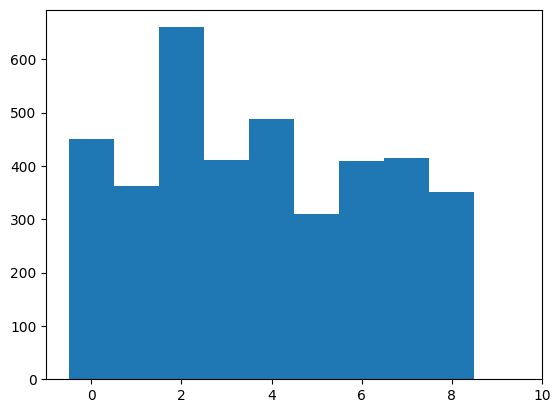

In [16]:
np_losses = all_loss.detach().numpy()
# np_losses = np_losses[np_losses[:, 0] > 0.1]
print(np_losses.shape)
fig = plt.figure()
plt.hist(np_losses[indi,1], bins= [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

(4425, 2)


(array([28., 12., 48., 95., 83., 92., 79., 84., 45.,  0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

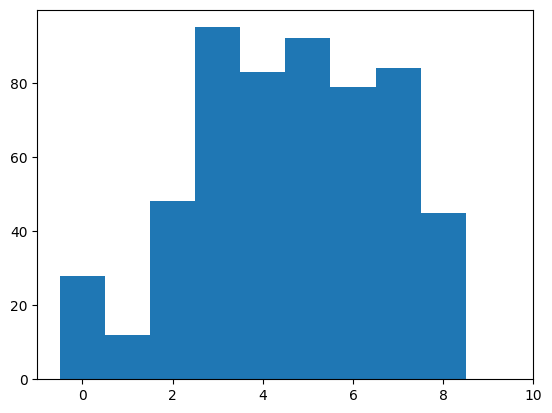

In [17]:
np_losses = all_loss.detach().numpy()
# np_losses = np_losses[np_losses[:, 0] > 0.16]
print(np_losses.shape)
fig = plt.figure()
plt.hist(np_losses[indi_bad,1], bins= [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

torch.Size([4425])


(array([207., 123., 178., 273., 370., 485., 617., 705., 730., 737.]),
 array([4.41765069e-09, 1.99997492e-04, 3.99990560e-04, 5.99983614e-04,
        7.99976697e-04, 9.99969780e-04, 1.19996280e-03, 1.39995595e-03,
        1.59994897e-03, 1.79994211e-03, 1.99993514e-03]),
 <BarContainer object of 10 artists>)

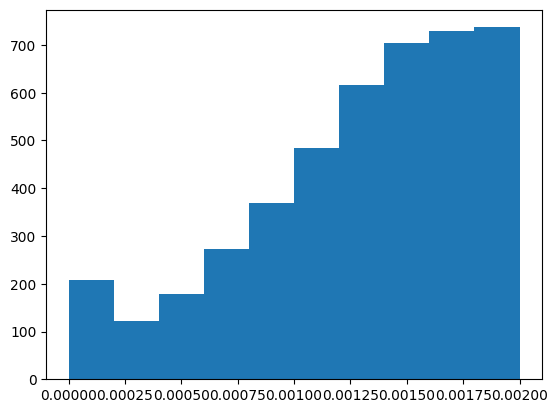

In [18]:
deformation_depth = torch.max(real_values_dict["test"]["depth"], dim=1)[0]
print(deformation_depth.shape)
fig = plt.figure()
plt.hist(deformation_depth)


In [19]:
deformation_test = real_values_dict["test"]

contact_points = deformation_test["contact_points"]

good_contacts = contact_points[indi]
bad_contacts = contact_points[indi_bad]
print(good_contacts.shape)
print(bad_contacts.shape)

torch.Size([3859, 3])
torch.Size([566, 3])


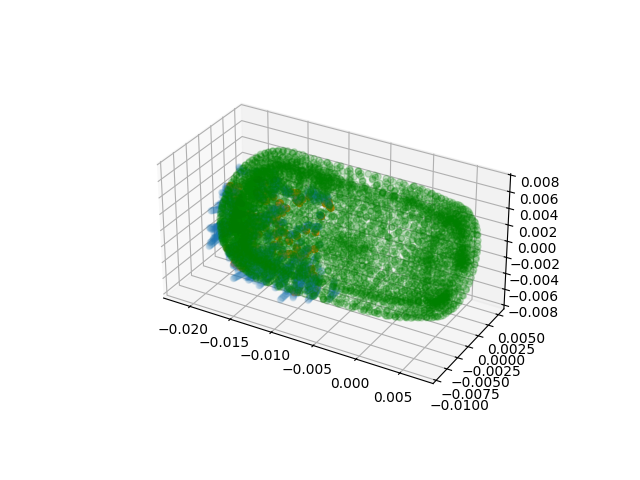

In [20]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(good_contacts[:, 0], good_contacts[:, 1], good_contacts[:, 2], alpha=0.1)
ax.scatter(bad_contacts[:, 0], bad_contacts[:, 1], bad_contacts[:, 2])
tt = target_decoded.numpy()[0] * deformation_norm_s[1] + deformation_norm_s[0]
ax.scatter(tt[:, 0], tt[:, 1], tt[:, 2], color="green", alpha=0.2)
ax.set_box_aspect((100, 50, 50))

(19,)
(19,)


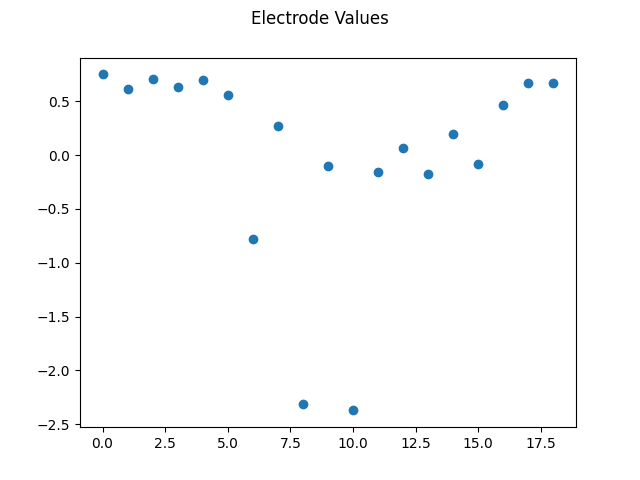

In [21]:
%matplotlib widget




fig = plt.figure()
fig.suptitle('Electrode Values')
ax = fig.add_subplot(1, 1, 1)
print(real_inp.numpy().shape)
print(np.arange(19).shape)
ax.scatter(np.arange(19), real_inp.numpy())
plt.show()

tensor([[[-0.3881,  0.2524, -1.6577],
         [-0.3763,  0.4306, -1.7544],
         [-0.1746,  0.3016, -1.7392],
         ...,
         [ 1.1365, -0.9999, -0.6878],
         [ 1.4148, -0.8860,  0.7596],
         [-0.5561,  0.7977, -0.6843]]])


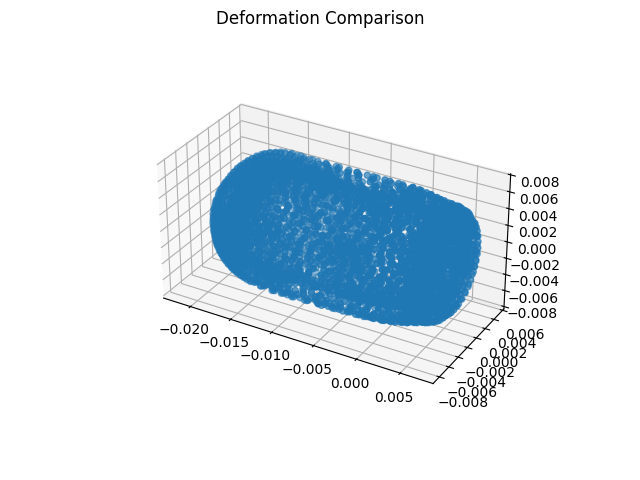

In [22]:
%matplotlib widget
print(real_predicted)
fig = plt.figure()
fig.suptitle('Deformation Comparison')
ax = fig.add_subplot(1, 1, 1, projection='3d')
real_predicted = real_predicted.numpy()[0] * deformation_norm_s[1] + deformation_norm_s[0]
ax.scatter(real_predicted[:, 0], real_predicted[:, 1], real_predicted[:, 2])
ax.set_box_aspect((100,50, 50))
plt.show()

[[-2.1360207e-02 -7.9257891e-04 -1.9504278e-04]
 [-2.1335389e-02 -7.9331883e-05 -1.9676649e-04]
 [-2.1284372e-02 -6.2700885e-04  4.5716672e-04]
 ...
 [-9.6851336e-03  3.4789157e-03  1.3713274e-04]
 [-8.7118596e-03  3.4740486e-03  3.5466633e-03]
 [-8.7928139e-03  3.4804284e-03 -3.5171104e-03]]


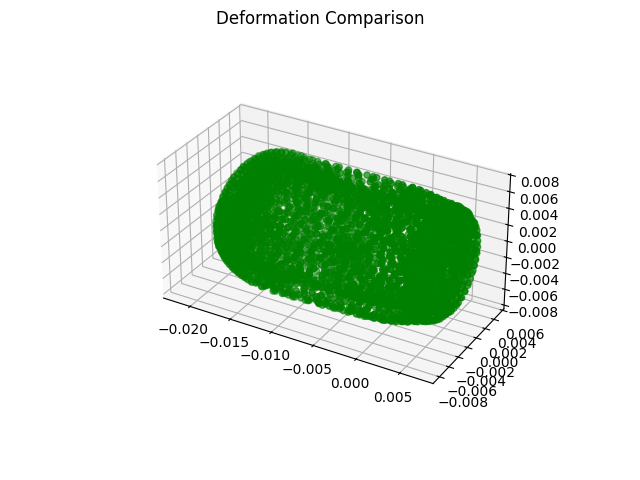

In [23]:
%matplotlib widget
print(real_predicted)
fig = plt.figure()
fig.suptitle('Deformation Comparison')
ax = fig.add_subplot(1, 1, 1, projection='3d')
target_decoded = target_decoded.numpy()[0] * deformation_norm_s[1] + deformation_norm_s[0]
ax.scatter(target_decoded[:, 0], target_decoded[:, 1], target_decoded[:, 2], color="green")
ax.set_box_aspect((100,50, 50))
plt.show()

[[-2.1341838e-02 -6.9977780e-04 -3.7098007e-04]
 [-2.1327415e-02 -1.0146963e-05 -3.7748678e-04]
 [-2.1264851e-02 -5.2944984e-04  2.7871600e-04]
 ...
 [-9.6850665e-03  3.4789131e-03  1.3713965e-04]
 [-8.7087294e-03  3.4741480e-03  3.5463031e-03]
 [-8.7902201e-03  3.4809832e-03 -3.5156617e-03]]


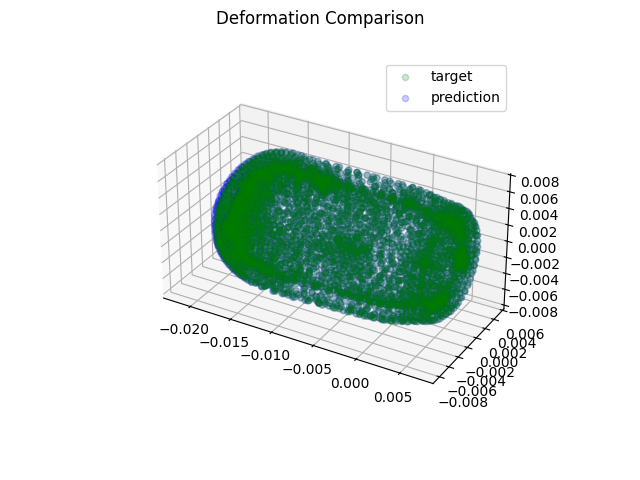

(4246, 3)
(4246, 3)
(4246,)
[1.5226124e-01 1.1045802e-01 1.4197125e-01 ... 3.1301955e-05 9.0396340e-04
 1.5633815e-03]
0.07332741
0.85292536


In [57]:
%matplotlib widget
print(real_predicted)
fig = plt.figure()
fig.suptitle('Deformation Comparison')
ax = fig.add_subplot(1, 1, 1, projection='3d')
# real_target = real_target.numpy()[0] * deformation_norm_s[1] + deformation_norm_s[0]
ax.scatter(target_decoded[:, 0], target_decoded[:, 1], target_decoded[:, 2], label="target", color="green", alpha=0.2)
ax.scatter(real_predicted[:, 0], real_predicted[:, 1], real_predicted[:, 2], label="prediction", color="blue", alpha=0.2)
ax.set_box_aspect((100,50, 50))
ax.legend()
plt.show()

print(target_decoded.shape)
print(real_predicted.shape)
real_loss = np.linalg.norm(target_decoded - real_predicted, axis=1) * 1000
print(real_loss.shape)
print(real_loss)
print(np.mean(real_loss))
print(np.max(real_loss))

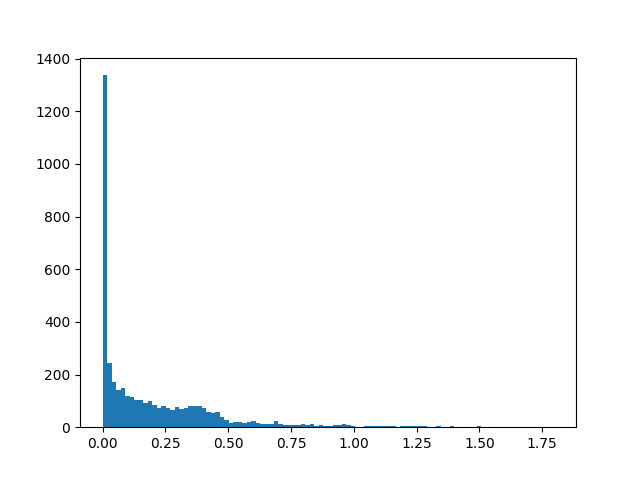

In [25]:
fig = plt.figure()
plt.hist(real_loss, bins=100)
plt.show()

[[-2.1277141e-02 -6.1888248e-04 -4.4621606e-04]
 [-2.1313652e-02  7.1212649e-05 -4.3433171e-04]
 [-2.1224031e-02 -4.5708567e-04  2.2921071e-04]
 ...
 [-9.6851941e-03  3.4789406e-03  1.3708799e-04]
 [-8.7100388e-03  3.4739077e-03  3.5473790e-03]
 [-8.7924944e-03  3.4818053e-03 -3.5138440e-03]]
(4246, 3)
(4246, 3)
[[-0.0213497  -0.00081547 -0.00011982]
 [-0.02132933 -0.00010031 -0.00011994]
 [-0.02128566 -0.00065114  0.00052788]
 ...
 [-0.00968517  0.00347893  0.00013714]
 [-0.00871373  0.0034739   0.00354667]
 [-0.00879303  0.00348029 -0.00351695]]


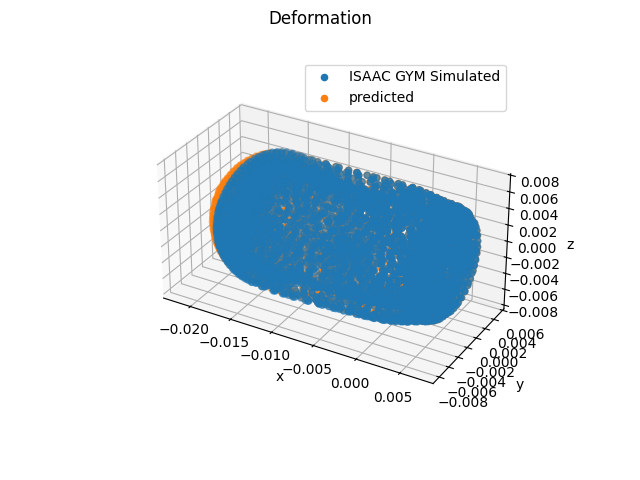

In [26]:
import h5py

acc_ds = torch.load
# print(ac_real.shape)
# ac_real = (ac_real - deformation_norm_s[0]) / deformation_norm_s[1]
ac_real = real_target.to("cpu").detach().numpy() * deformation_norm_s[1] + deformation_norm_s[0]
print(ac_real)
print(deformation_norm_s[0].shape)
print(deformation_norm_s[1].shape)
%matplotlib widget
print(real_predicted)
fig = plt.figure()
fig.suptitle('Deformation')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(ac_real[:, 0], ac_real[:, 1], ac_real[:, 2], label="ISAAC GYM Simulated")
ax.scatter(real_predicted[:, 0], real_predicted[:, 1], real_predicted[:, 2], label="predicted")
ax.set_box_aspect((100,50, 50))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

[[-0.0213497  -0.00081547 -0.00011982]
 [-0.02132933 -0.00010031 -0.00011994]
 [-0.02128566 -0.00065114  0.00052788]
 ...
 [-0.00968517  0.00347893  0.00013714]
 [-0.00871373  0.0034739   0.00354667]
 [-0.00879303  0.00348029 -0.00351695]]


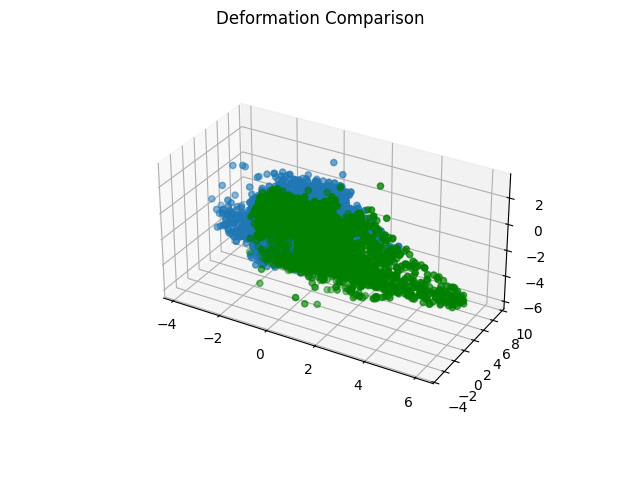

In [27]:
%matplotlib widget
print(real_predicted)
fig = plt.figure()
fig.suptitle('Deformation Comparison')
ax = fig.add_subplot(1, 1, 1, projection='3d')
#  = real_predicted_alt.numpy()[0] * deformation_norm_s[1] + deformation_norm_s[0]
ax.scatter(real_predicted_alt[:, 0], real_predicted_alt[:, 1], real_predicted_alt[:, 2])
ax.scatter(real_target[:, 0], real_target[:, 1], real_target[:, 2], label="target", color="green")
ax.set_box_aspect((100,50, 50))
plt.show()

In [31]:
import tqdm
latent_test = iter(latent_space_module.test_dataloader())

class Wrapper:
    def __init__(self, x):
        self.x = torch.unsqueeze(x, dim=0).to("cpu")
        self.edge_index = 0
        self.num_graphs = 1

all_predicted_real = []
all_predicted_latent = []
all_decoded_target = []
deformation_network = deformation_network.to("cpu")
all_loss = []
with (torch.no_grad()):
    for batch in tqdm.tqdm(latent_test):
        inp, target = batch
        # real_inp, real_target= deformation_test["real_value"][index + 1], deformation_test["real_deformation"][index + 1]
            
            
        target_decoded = deformation_network.decode(target.to("cpu")).to("cpu")
        print(target_decoded.shape)
        print(target_decoded)
        # target_decoded = target_decoded.reshape(-1, deformation_network.filters[0])
        print(target_decoded)
        print(target_decoded.shape)
        
        
        all_decoded_target.append(target_decoded)
        
        reconstructed_target = deformation_network.forward(Wrapper(target_decoded))[0][0].to("cpu")
        #print(target_decoded.shape)
        print(reconstructed_target.shape)
        loss = torch.sqrt(
            torch.nn.functional.mse_loss(
                target_decoded * deformation_norm_dict["std"],
                reconstructed_target * deformation_norm_dict["std"]
            )
        ) * 1000
        all_loss.append(loss) 
        break
        #real_predicted_alt, _, _, _ = deformation_network.forward(FEMNetworkInput(torch.unsqueeze(real_target.to("cpu"), 0)))
        #real_predicted_alt = real_predicted_alt[0].to("cpu")
            


  0%|          | 0/4425 [00:00<?, ?it/s]/tmp/ipykernel_1985533/3852455018.py:35: UserWarning: Using a target size (torch.Size([4246, 3])) that is different to the input size (torch.Size([1, 4246, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(
  0%|          | 0/4425 [00:00<?, ?it/s]

torch.Size([1, 4246, 3])
tensor([[[-0.2731, -0.1530, -0.7064],
         [-0.2131, -0.0682, -0.7727],
         [-0.2484, -0.1714, -0.7871],
         ...,
         [ 1.1184, -0.7038, -1.1111],
         [ 0.5000,  0.1077, -0.9262],
         [-0.8619,  1.1346, -0.1744]]])
tensor([[[-0.2731, -0.1530, -0.7064],
         [-0.2131, -0.0682, -0.7727],
         [-0.2484, -0.1714, -0.7871],
         ...,
         [ 1.1184, -0.7038, -1.1111],
         [ 0.5000,  0.1077, -0.9262],
         [-0.8619,  1.1346, -0.1744]]])
torch.Size([1, 4246, 3])
torch.Size([4246, 3])


In [32]:
all_loss = torch.tensor(all_loss)
print(torch.mean(all_loss))

tensor(0.0068)


[[-0.0213497  -0.00081547 -0.00011982]
 [-0.02132933 -0.00010031 -0.00011994]
 [-0.02128566 -0.00065114  0.00052788]
 ...
 [-0.00968517  0.00347893  0.00013714]
 [-0.00871373  0.0034739   0.00354667]
 [-0.00879303  0.00348029 -0.00351695]]
tensor([[[-0.2731, -0.1530, -0.7064],
         [-0.2131, -0.0682, -0.7727],
         [-0.2484, -0.1714, -0.7871],
         ...,
         [ 1.1184, -0.7038, -1.1111],
         [ 0.5000,  0.1077, -0.9262],
         [-0.8619,  1.1346, -0.1744]]])


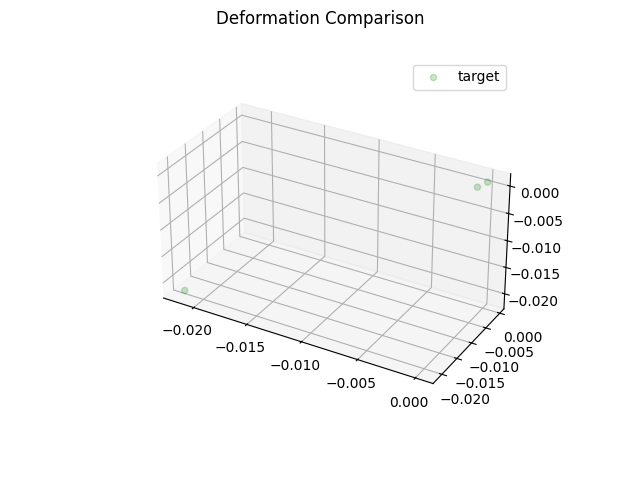

torch.Size([1, 4246, 3])
(4246, 3)
(1, 3)
[[3.146118  9.572004  9.6902685]]
7.4694633
9.6902685


In [33]:
%matplotlib widget
print(real_predicted)
fig = plt.figure()
fig.suptitle('Deformation Comparison')
ax = fig.add_subplot(1, 1, 1, projection='3d')
# real_target = real_target.numpy()[0] * deformation_norm_s[1] + deformation_norm_s[0]
print(target_decoded)
target_decoded = target_decoded * deformation_norm_s[1] + deformation_norm_s[0]
reconstructed_target = reconstructed_target * deformation_norm_s[1] + deformation_norm_s[0]
ax.scatter(target_decoded[:, 0], target_decoded[:, 1], target_decoded[:, 2], label="target", color="green", alpha=0.2)
#ax.scatter(reconstructed_target[:, 0], reconstructed_target[:, 1], reconstructed_target[:, 2], label="prediction", color="blue", alpha=0.2)
ax.set_box_aspect((100,50, 50))
ax.legend()
plt.show()

print(target_decoded.shape)
print(real_predicted.shape)
real_loss = np.linalg.norm(target_decoded - real_predicted, axis=1) * 1000
print(real_loss.shape)
print(real_loss)
print(np.mean(real_loss))
print(np.max(real_loss))

In [34]:
print(target_decoded.shape)

torch.Size([1, 4246, 3])


Convert Test-Dataset

In [35]:
print(deformation_norm_s[1].shape)



(4246, 3)


In [36]:
test = torch.rand((10,4246, 3))

In [51]:
import tqdm
latent_test = iter(latent_space_module.test_dataloader())

all_predicted_real = []
all_predicted_latent = []
all_decoded_target = []
deformation_network = deformation_network.to("cpu")
with torch.no_grad():
    for batch in tqdm.tqdm(latent_test):
        inp, target = batch
        # real_inp, real_target= deformation_test["real_value"][index + 1], deformation_test["real_deformation"][index + 1]
    
        predicted_latent = model.forward(inp.to("cpu")).to("cpu")
        all_predicted_latent.append(predicted_latent)
            
        # predicted_loss = torch.nn.functional.mse_loss(predicted_latent, target)
        real_predicted = deformation_network.decode(predicted_latent.to("cpu")).to("cpu")
        all_predicted_real.append(real_predicted)
            
            
        target_decoded = deformation_network.decode(target.to("cpu")).to("cpu")
        all_decoded_target.append(target_decoded)
            
        #real_predicted_alt, _, _, _ = deformation_network.forward(FEMNetworkInput(torch.unsqueeze(real_target.to("cpu"), 0)))
        #real_predicted_alt = real_predicted_alt[0].to("cpu")
            


        
res = {
    "decoded_predicted": torch.cat(all_predicted_real),
    "latent_predicted": torch.cat(all_predicted_latent),
    "decoded_target": torch.cat(all_decoded_target),
    "trajectories": real_values_dict["test"]["trajects"],
    "indenter_types": torch.squeeze(real_values_dict["test"]["indenter_types"], dim=1),
    "real_value_norm": real_values_dict["test"]["real_value"],
    "real_value": torch.tensor(real_values_dict["test"]["real_value"].numpy() * value_norms[1] + value_norms[0])
}

#torch.save(res, "../../Data/datasets/test_ds/test_ds_indenter_0_0.005_depth_filter.pt")

100%|██████████| 479/479 [00:07<00:00, 66.96it/s]


In [19]:
print(res["decoded_predicted"].shape)
print(res["latent_predicted"].shape)
print(res["decoded_target"].shape)
print(res["indenter_types"].shape)

torch.Size([990, 4246, 3])
torch.Size([990, 128])
torch.Size([990, 4246, 3])
torch.Size([990])


Visualize problematic Contacts

In [3]:
rejects_dict = torch.load("../../Data/datasets/value_def_dataset/reject_dataset_all_data_depth_filter.pt")

In [4]:
indenter_ids = torch.squeeze(rejects_dict["test"]["indenter_type"])
print(indenter_ids.shape)

torch.Size([1403])


NameError: name 'indenter_ids' is not defined

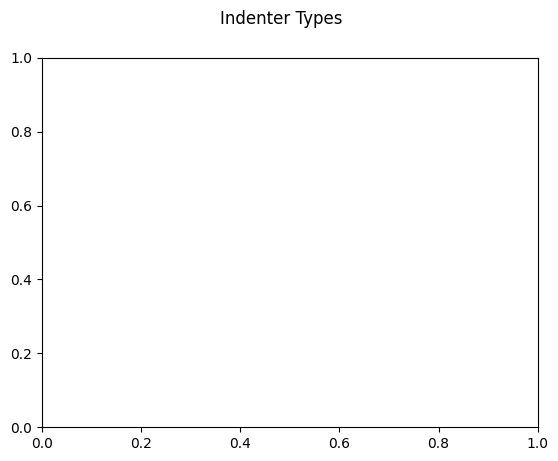

In [17]:
fig = plt.figure()
fig.suptitle('Indenter Types')
ax = fig.add_subplot(1, 1, 1)
ax.hist(indenter_ids, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
ax.set_xlabel("Indenter Type")
ax.set_ylabel("Amount")
plt.show()

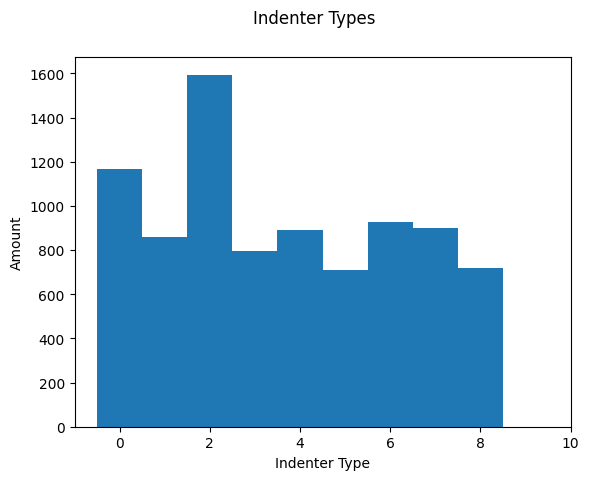

In [8]:
fig = plt.figure()
fig.suptitle('Indenter Types')
ax = fig.add_subplot(1, 1, 1)
ax.hist(torch.squeeze(real_values_dict["test"]["indenter_types"], dim=1), bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
ax.set_xlabel("Indenter Type")
ax.set_ylabel("Amount")
plt.show()


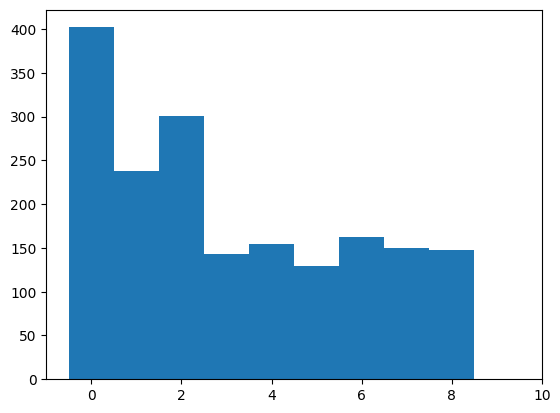

In [9]:
fig = plt.figure()
plt.hist(real_values_dict["validation"]["indenter_types"], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
plt.show()

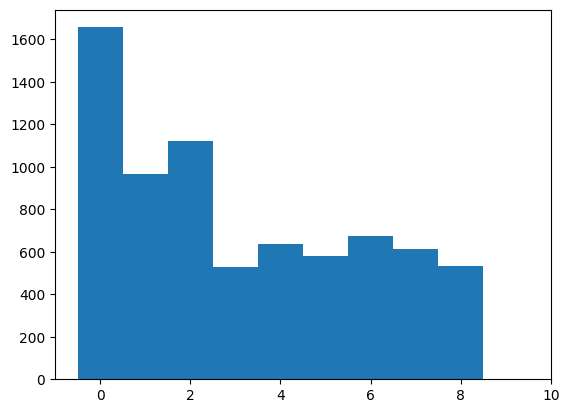

In [10]:
fig = plt.figure()
plt.hist(real_values_dict["train"]["indenter_types"], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
plt.show()